# Diffusion for noobs
## aka Step-by-Step Diffusion meets Simon Prince's 1D Diffusion Tutorial

First, we're going to need some data. We'll start with UDL's mixture of 1D Gaussians



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from operator import itemgetter
#from PIL import Image
from IPython.display import Image as dispImage
from IPython.display import clear_output

# True distribution is a mixture of four Gaussians
def norm_pdf(x, mu, sigma):
    return np.exp(-0.5 * (x-mu) * (x-mu) / (sigma * sigma)) / np.sqrt(2*np.pi*sigma*sigma)
class TrueDataDistribution:
  # Constructor initializes parameters
  def __init__(self):
    self.mu = [1.5, -0.216, 0.45, -1.875]
    self.sigma = [0.3, 0.15, 0.525, 0.075]
    self.w = [0.2, 0.3, 0.35, 0.15]

  # Return PDF
  def pdf(self, x):
    return(self.w[0] *norm_pdf(x,self.mu[0],self.sigma[0]) +  self.w[1] *norm_pdf(x,self.mu[1],self.sigma[1]) + self.w[2] *norm_pdf(x,self.mu[2],self.sigma[2]) + self.w[3] *norm_pdf(x,self.mu[3],self.sigma[3]))

  # Draw samples
  def sample(self, n):
    hidden = np.random.choice(4, n, p=self.w)
    epsilon = np.random.normal(size=(n))
    mu_list = list(itemgetter(*hidden)(self.mu))
    sigma_list = list(itemgetter(*hidden)(self.sigma))
    return mu_list + sigma_list * epsilon

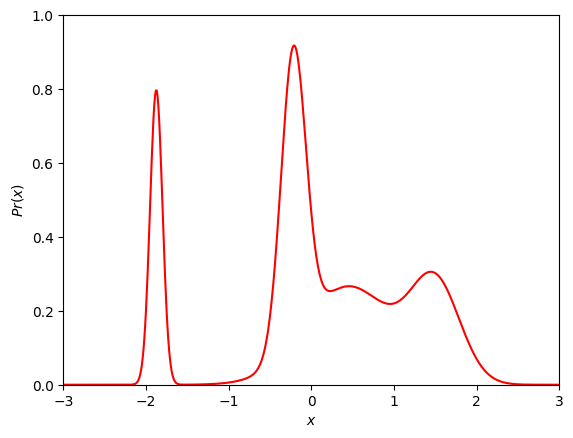

In [2]:
# Define ground truth probability distribution that we will model
true_dist = TrueDataDistribution()
# Let's visualize this
x_vals = np.arange(-3,3,0.01)
pr_x_true = true_dist.pdf(x_vals)
fig,ax = plt.subplots()
ax.plot(x_vals, pr_x_true, 'r-')
ax.set_xlabel("$x$")
ax.set_ylabel("$Pr(x)$")
ax.set_ylim(0,1.0)
ax.set_xlim(-3,3)
plt.show()

Broadly speaking, our goal is to be able to produce samples from some complex (& high dimensional) distribution, whose true parameters are unknown. The trick that Diffusion models employ is that they learn to **progressively** transform from an easy-to-sample distribuion (typically a Gaussian) to a complex distribution. By progressively transform, I mean that instead of trying to directly sample from the target distribution given some sample from our Gaussian, they decompose the problem into a sequence of sampling steps.

Ok that's nice, but how do we actually do that? We define a **forward process** which corrupts our data and then learn to approximate a **reverse process** that undoes the corruption.

Starting with the **forward process**, we sample some $x\sim p^{*}(x)$ (our target distribution). Next, we set $z_{0}=x$, define our corrupting process as <br /> $z_{t+1}=z_{t}+\epsilon, \epsilon\sim\mathcal{N}(0,\sigma^{2}\mathbf{I})$[^1]. i.e. Iteratively add Gaussian noise to the data, with some small scale $\sigma$.

Notice that $\Pr(z_{1}|z_{0})=\mathcal{N}(z_{0},\sigma^{2}\mathbf{I})$, and that in general,
$\Pr(z_{t}|z_{t-1})=\mathcal{N}(z_{t-1},\sigma^{2}\mathbf{I})$. We can therefore represent our
joint distribution over all $z_{t}$ as <br />
$\Pr(z_{1\cdots T}) = \prod^{T}_{t=1}\Pr(z_{t}|z_{t-1})$. A really conveniant property of this forward process is that we can calculate $\Pr(z_{t}|z_{0})$ in a single step $\forall t\in [1,\cdots,T]$. We can show this via induction:<br />

* **Claim**: $\Pr(z_{t}|z_{0}) = z_{0} + \epsilon, \epsilon \sim \mathcal{N}(0,t\sigma^{2}\mathbf{I})$
* **Base Case**: <br />
&nbsp;&nbsp;$\Pr(z_{1}|z_{0})=z_{0}+\sigma\epsilon_{1}$
$\Pr(z_{2}|z_{1})=z_{1}+\sigma\epsilon_{2}=(z_{0}+\sigma\epsilon_{1})+\sigma\epsilon_{2}$. <br />
&nbsp;&nbsp;Since $\sigma\epsilon_{1}$ and $\sigma\epsilon_{2}$ are independent Gaussian random variables, we can write $\Pr(z_{2}|z_{1})$ as $z_{0}+\epsilon, \epsilon\sim \mathcal{N}(0, 2\sigma^{2}\mathbf{I})$
* **Inductive Hypothesis**: <br />
&nbsp;&nbsp;$\Pr(z_{i}|z_{0})=z_{0}+\epsilon,\epsilon\sim \mathcal{N}(0, i\sigma^{2}\mathbf{I})$
* **Inductive Step**: <br />
&nbsp;&nbsp;$\Pr(z_{i+1}|z_{i})=z_{i}+\epsilon_{i+1},\epsilon_{i+1}\sim \mathcal{N}(0, \sigma^{2}\mathbf{I})$<br />
&nbsp;&nbsp;Then, by our inductive hypothesis, $\Pr(z_{i+1}|z_{i})=z_{0}+\epsilon+\epsilon_{i+1}$, and reusing our argument from the base case;<br/>
&nbsp;&nbsp;$\Pr(z_{i+1}|z_{i})=\Pr(z_{i+1}|z_{0})=z_{0}+\epsilon, \epsilon\sim\mathcal{N}(0,(i+1)\sigma^{2})$<br/>
Hence, by the property of mathematical induction, $\Pr(z_{t}|z_{0}) = z_{0} + \epsilon, \epsilon \sim \mathcal{N}(0,t\sigma^{2}\mathbf{I})$.

[^1]: The original formulation had some different scaling which we will discuss later

Now lets take a look at the marginals of each $z_{t}$.

Recall, $\Pr(z_{t})=\int{\Pr(z_{t}|x)\Pr(x)d{x}}$. Since we have access to $\Pr(x)$, we can approximate the marginal at each $t$ with a finite set of points.

In [3]:
def diffusion_marginal(x_plot_vals, pr_x_true, t, sigma):
    # If time is zero then marginal is just original distribution
    if t == 0:
        return pr_x_true

    # The thing we are computing
    marginal_at_time_t = np.zeros_like(pr_x_true)

    for x0,pr_x in zip(x_plot_vals,pr_x_true):
        #We multiply by 0.01 since that's our step size
        marginal_at_time_t += 0.01*pr_x*norm_pdf(x_plot_vals,x0,t*sigma)

    return marginal_at_time_t

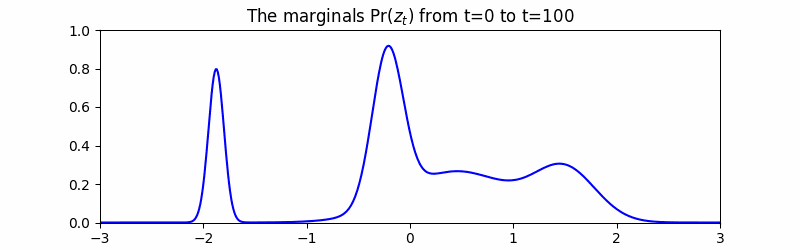

In [16]:
T = 100
sigma = 0.01511

x_plot_vals = np.arange(-3,3,0.01)
marginal_distributions = np.zeros((T+1,len(x_plot_vals)))
plt.ioff()
fig, ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-3,3])
ax.set_ylim([0,1.0])
ax.set_title('The marginals $\Pr(z_{t})$ from t=0 to t=100')

artists=[]

for t in range(T+1):
  marginal_distributions[t,:] = diffusion_marginal(x_plot_vals, pr_x_true , t, sigma)
  cont = ax.plot(x_plot_vals, marginal_distributions[t,:], 'b-')
  artists.append(cont)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=200)
ani.save(filename="/tmp/diffusion_marginal.gif", writer="pillow")

plt.ion()
with open("/tmp/diffusion_marginal.gif",'rb') as f:
    display(dispImage(data=f.read(), format='png'))




As one might expect, the marginals of our forward process become more and more Gaussian.

If we could map a sample marginally distributed as $p_{t}$ to a sample marginally distributed as $p_{t-1}$, then we could reverse the above process! Ideally, this would look like $\Pr(z_{t-1}|z_{t}=z)$. However, this would require that we learn a generative model for $\Pr(z_{t-1}|z_{t})$ for **every** $z_{t}$.

Fortunately, if the per-step noise $\sigma$, is sufficiently small, the conditional distribution $\Pr(z_{t-1}|z_{t})$ is itself close to being Gaussian. So, $\forall t \in [0,\cdots,T]$ and $z\in\mathbb{R}^{d}$, $\exists \mu\in\mathbb{R}^{d}$ such that, <br />
$\Pr(z_{t-1}|z_{t}=z)\approx \mathcal{N}(z_{t-1};\mu,\sigma^{2})$

Now, instead of having to learn some arbitrary distribution, we just need to learn the mean:
$\mu_{t-1}(z_{t})$ ($\mu_{t-1}$ : $\mathbb{R}^{d} \mapsto \mathbb{R}^{d}$). This is a much simpler problem, which can be solved via regression loss:<br />
$\mu_{t-1}(z):=\mathbb{E}\left[z_{t-1}|z_{t}=z\right]$<br />
$\implies \mu_{t-1}= \text{argmin}_{f:\mathbb{R}^{d} \mapsto \mathbb{R}^{d}}$ $\mathbb{E}_{z_{t},z_{t-1}}\left \lVert f(z_{t}) - z_{t-1} \right \rVert_{2}^{2}$<br />
$= \text{argmin}_{f:\mathbb{R}^{d} \mapsto \mathbb{R}^{d}}$ $\mathbb{E}_{z_{t-1},\epsilon\sim\mathcal{N}(0,\sigma^{2})}\left \lVert f(z_{t-1}+\epsilon) - z_{t-1} \right \rVert_{2}^{2}$

Ok. So we just need to learn $T$, functions $\{\mu_{t}\}$. In the training phase, we estimate these functions from i.i.d. samples of $x\sim p^{*}$ by optimising our earlier denoising objective. Then, in order to produce a sample from $p^{*}$, we use the estimated functions to construct the following stochastic reverse sampler: <br />
$\hat{z}_{t-1}\gets \mu_{t-1}(z_{t})+\epsilon,\epsilon\sim\mathcal{N}(0,\frac{1}{T}\sigma^{2}_{q})$, where $\sigma^{2}_{q}$ is the desired terminal variance.


In [40]:
import torch
import torch.nn as nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"


class MuNet(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1,2*h),
            nn.ReLU(),
            nn.Linear(2*h,h),
            nn.ReLU(),
            nn.Linear(h,1),
            nn.ReLU(),
        )
    def forward(self,x):
        return self.layers(x)


In [57]:
mus = [MuNet(32).to(device) for i in range(T)]
n_samples = 100_000
x_train = np.array(true_dist.sample(n_samples))
x_train = 2*((x_train+3)/(6))-1
batch_size = 1024
n_epochs= 5
sigma = 0.001
lr=1e-4


for t,mu_model in enumerate(mus):
    t=t+1
    optimiser = torch.optim.Adam(mu_model.parameters(),lr=lr)
    for e in range(n_epochs):
        print(f"*****Training mu_{t}*****")
        running_loss = 0
        np.random.shuffle(x_train)
        for i in range(n_samples//batch_size+1):
            optimiser.zero_grad()
            batch_idx = min(n_samples-1,(i+1)*batch_size)
            labels = torch.tensor(x_train[:batch_idx],device=device,dtype=torch.float32).unsqueeze(1)
            noised_inputs = labels+ t*sigma*torch.randn_like(labels)
            outputs=mu_model(noised_inputs)
            loss = torch.nn.functional.mse_loss(outputs,labels)
            loss.backward()
            running_loss += loss.item()
            optimiser.step()
            if i%100:
                print(f'[Epoch: {e+1}/{n_epochs} Batch {i}] Loss: {running_loss/100}')
                running_loss=0
            #print(loss)
        clear_output(wait=True)



*****Training mu_100*****
[Epoch: 5/5 Batch 1] Loss: 0.001462055817246437
[Epoch: 5/5 Batch 2] Loss: 0.0007024204730987549
[Epoch: 5/5 Batch 3] Loss: 0.0007023149728775024
[Epoch: 5/5 Batch 4] Loss: 0.0006994291394948959
[Epoch: 5/5 Batch 5] Loss: 0.0006997309625148773
[Epoch: 5/5 Batch 6] Loss: 0.0006997665762901306
[Epoch: 5/5 Batch 7] Loss: 0.0006879867613315583
[Epoch: 5/5 Batch 8] Loss: 0.0006918486207723618
[Epoch: 5/5 Batch 9] Loss: 0.0006803508847951889
[Epoch: 5/5 Batch 10] Loss: 0.000684191882610321
[Epoch: 5/5 Batch 11] Loss: 0.0006900574266910553
[Epoch: 5/5 Batch 12] Loss: 0.0006902314722537995
[Epoch: 5/5 Batch 13] Loss: 0.0006885819882154465
[Epoch: 5/5 Batch 14] Loss: 0.0006857779622077942
[Epoch: 5/5 Batch 15] Loss: 0.0006797870993614196
[Epoch: 5/5 Batch 16] Loss: 0.0006738097220659256
[Epoch: 5/5 Batch 17] Loss: 0.0006704878807067871
[Epoch: 5/5 Batch 18] Loss: 0.0006687488406896591
[Epoch: 5/5 Batch 19] Loss: 0.0006667714565992356
[Epoch: 5/5 Batch 20] Loss: 0.00066

In [85]:
def sample(models, T, sigma_t, n_samples):
    # Create the output array
    # Each row represents a time step, first row will be sampled data
    # Each column represents a different sample
    samples = np.zeros((T+1,n_samples))

    #Initialize the samples z_{T} at samples[T,:] from standard normal distribution
    samples[T,:]=np.random.normal(size=n_samples)
    with torch.no_grad():
    # For t=100...99..98... ...0
        for t in range(T,0,-1):
            clear_output(wait=True)
            display("Predicting z_{%d} from z_{%d}"%(t-1,t))
            #Predict samples[t-1,:] from samples[t,:] using the appropriate model
        
            torch_inputs = torch.tensor(samples[t,:],device=device,dtype=torch.float32).view(n_samples,1)
            samples[t-1,:] = (6*(0.5*((models[t-1]
                                    (torch_inputs))+1))-3).cpu().numpy().squeeze()


            # If not the last time step
            if t>0:
                # TODO Add noise to the samples at z_t-1 we just generated with mean zero, standard deviation sigma_t
                # Replace this line(1/T)*
                samples[t-1,:] = samples[t-1,:] + np.random.normal(loc=0,scale=sigma_t,size=n_samples)

    return samples

'Predicting z_{0} from z_{1}'

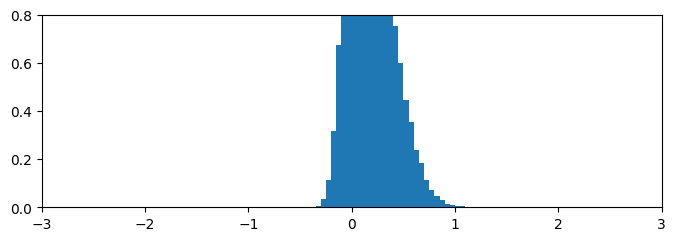

In [102]:
sigma = 0.1
n_samples = 100_000
samples=sample(mus,T,sigma,n_samples)

# Plot the data
sampled_data = samples[0,:]
bins = np.arange(-3,3.05,0.05)

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-3,3])
plt.hist(sampled_data, bins=bins, density =True)
ax.set_ylim(0, 0.8)
plt.show()

In [ ]:
fig, ax = plt.subplots()
t_vals = np.arange(0,101,1)
ax.plot(samples[:,0],t_vals,'r-')
ax.plot(samples[:,1],t_vals,'g-')
ax.plot(samples[:,2],t_vals,'b-')
ax.plot(samples[:,3],t_vals,'c-')
ax.plot(samples[:,4],t_vals,'m-')
ax.set_xlim([-3,3])
ax.set_ylim([101, 0])
ax.set_xlabel('value')
ax.set_ylabel('z_{t}')
plt.show()